In [1]:
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
# Read face image from zip file on the fly
faces = {}
with zipfile.ZipFile("C:\\Users\\91995\\OneDrive\\Desktop\\MLProject.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".jpg"):
            continue # not a face picture
        with facezip.open(filename) as image:
            # If we extracted files from zip, we can use cv2.imread(filename) instead
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)

Showing sample faces


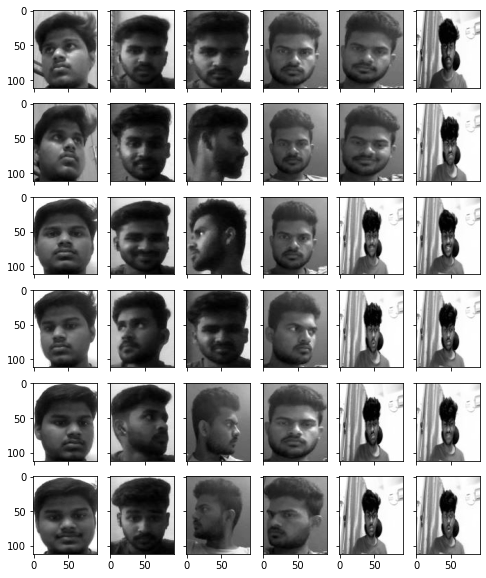

In [4]:
# Show sample faces using matplotlib
fig, axes = plt.subplots(6,6,sharex=True,sharey=True,figsize=(8,10))
faceimages = list(faces.values())[-36:] # take last 16 images
for i in range(36):
    axes[i%6][i//6].imshow(faceimages[i], cmap="gray")
print("Showing sample faces")
plt.show()

In [5]:
# Print some details
faceshape = list(faces.values())[1].shape
print("Face image shape:", faceshape)
 
classes = set(filename.split("/")[0] for filename in faces.keys())
print("Number of classes:", len(classes))
print("Number of images:", len(faces))

Face image shape: (112, 92)
Number of classes: 4
Number of images: 40


In [6]:
# Take classes 1-3 for eigenfaces, keep entire class 4 and
# image 10 of class 3 as out-of-sample test
facematrix = []
facelabel = []
for key,val in faces.items():
    if key.startswith("s5/"):
        continue # this is our test set
    if key == "s4/11.jpg":
        continue # this is our test set
    facematrix.append(val.flatten())
    facelabel.append(key.split("/")[0])

In [7]:
# Create a NxM matrix with N images and M pixels per image
facematrix = np.array(facematrix)
 
# Apply PCA and take first K principal components as eigenfaces
pca = PCA().fit(facematrix)
 
n_components = 80
eigenfaces = pca.components_[:n_components]

Showing the eigenfaces


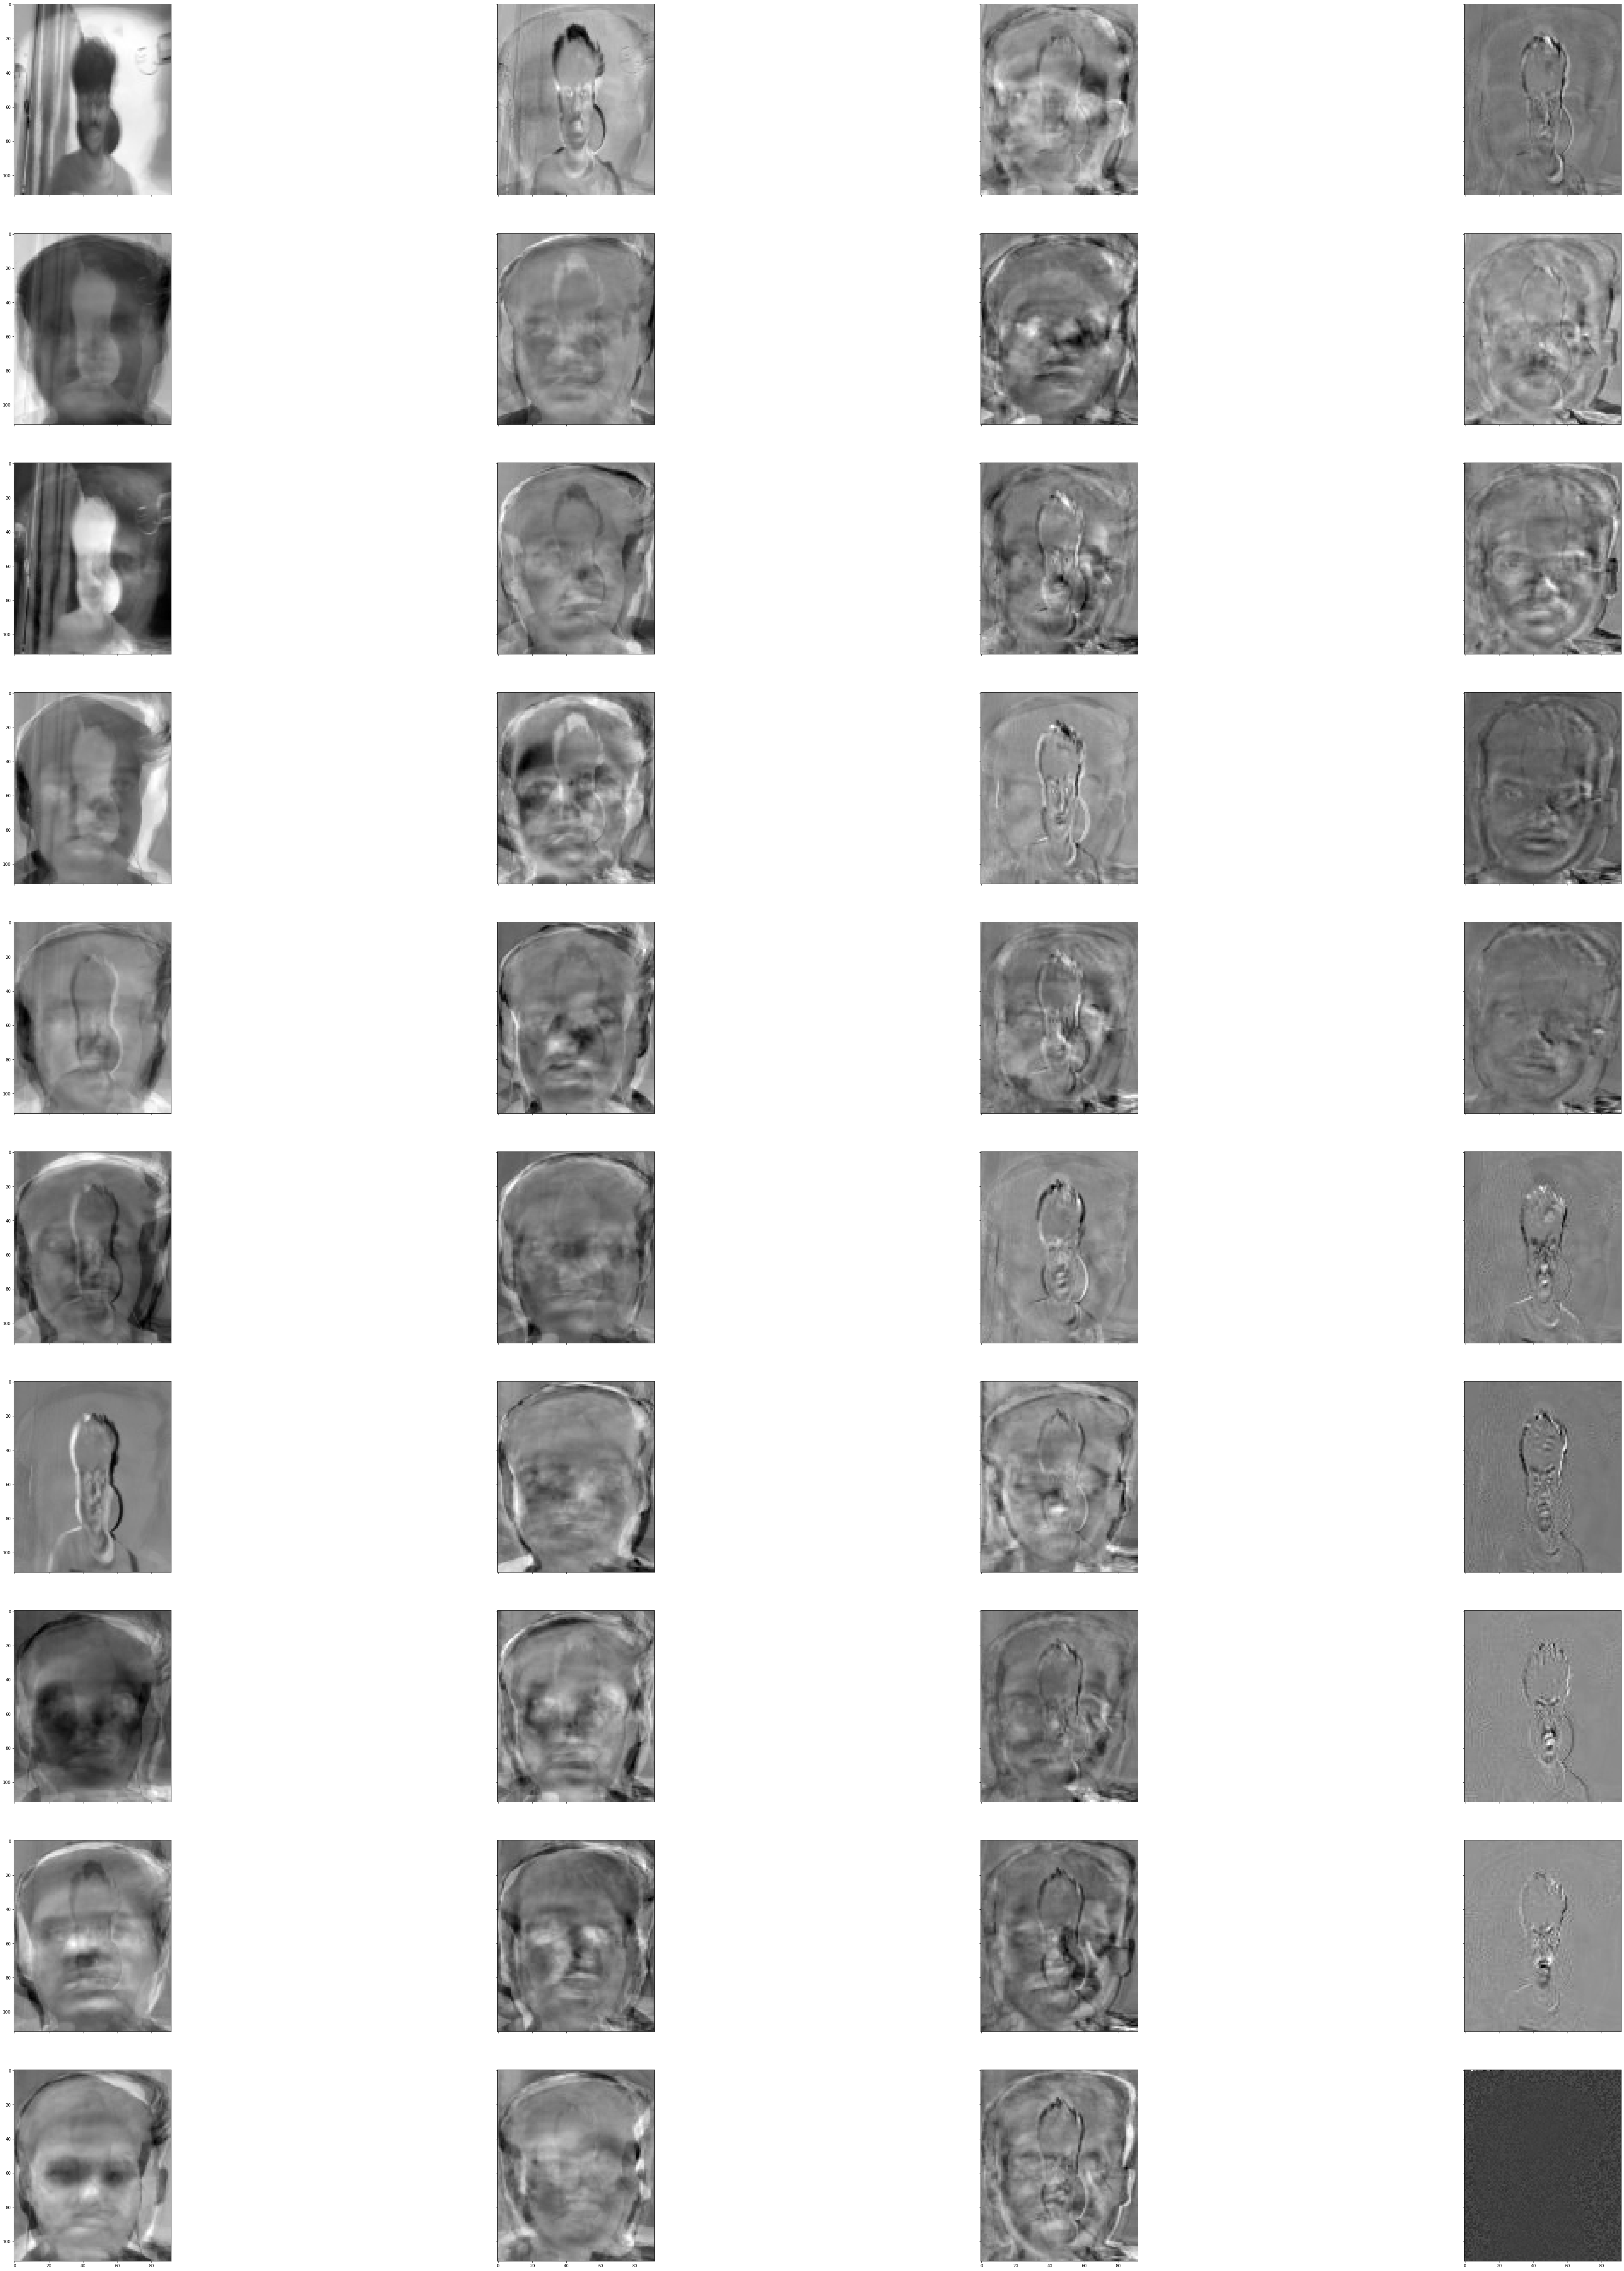

In [8]:
# Show the first 16 eigenfaces
fig, axes = plt.subplots(10,4,sharex=True,sharey=True,figsize=(80,100))
for i in range(40):
    axes[i%10][i//10].imshow(eigenfaces[i].reshape(faceshape), cmap="gray")
print("Showing the eigenfaces")
plt.show()

In [9]:
# Generate weights as a KxN matrix where K is the number of eigenfaces and N the number of samples
weights = []
for i in range(facematrix.shape[0]):
    weight = []
    for j in range(40):
        w = eigenfaces[j] @ (facematrix[i] - pca.mean_)
        weight.append(w)
    weights.append(weight)

Best match s2 with Euclidean distance 6107.699190


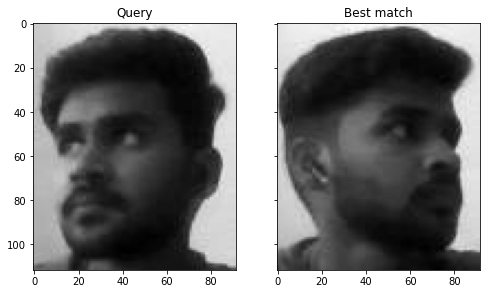

In [10]:
# Test on out-of-sample image of existing class
query = faces["s2/3.jpg"].reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best match")
plt.show()